# E-commerce Customer Churn Analysis
---

## 1. Business Understanding

### Context
Industri e-commerce berkembang pesat dan persaingan semakin ketat. Salah satu tantangan terbesar adalah mempertahankan pelanggan agar tetap bertransaksi. Fenomena customer churn (pelanggan berhenti berbelanja dalam periode tertentu) berdampak negatif pada pendapatan perusahaan karena:

- Kehilangan sumber pendapatan berulang (recurring revenue).
- Biaya akuisisi pelanggan baru (Customer Acquisition Cost) lebih tinggi daripada mempertahankan pelanggan lama.
- Penurunan loyalitas pelanggan dapat menurunkan pangsa pasar dan citra merek.

Dengan memahami pola perilaku pelanggan dan memprediksi churn lebih awal, perusahaan dapat melakukan intervensi tepat sasaran seperti promosi personal, program loyalitas, atau peningkatan kualitas layanan.

### Stakeholder
1. Manajemen & Strategi Perusahaan
    - Membutuhkan insight churn untuk menetapkan arah bisnis dan kebijakan retensi jangka panjang.

2. Tim Marketing & Customer Retention
    - Menggunakan prediksi churn untuk menargetkan kampanye promosi atau program loyalitas yang tepat sasaran.

3. Tim Customer Service
    - Memanfaatkan prediksi churn untuk memberikan pelayanan proaktif kepada pelanggan berisiko tinggi.

4. Tim Data Analyst & Data Scientist
    - Membangun, memelihara, dan memantau performa model prediksi churn, serta mengkomunikasikan hasil analisis ke tim bisnis.

### Problem Statements
- Tingkat churn pelanggan e-commerce perusahaan saat ini cukup tinggi, mengakibatkan potensi kerugian pendapatan yang signifikan.
- Belum ada sistem otomatis yang dapat mengidentifikasi pelanggan dengan risiko churn tinggi.
- Keputusan strategi retensi saat ini kurang terarah karena tidak didukung oleh analisis prediktif.

### Goals
- Membangun model prediktif untuk mengklasifikasikan apakah seorang pelanggan berpotensi churn atau tidak, berdasarkan data historis mereka.
- Mengidentifikasi faktor-faktor utama yang berkontribusi terhadap churn pelanggan, seperti kepuasan layanan, keluhan, durasi menjadi pelanggan, dan pola belanja.
- Memberikan insight bisnis kepada tim marketing dan layanan pelanggan agar dapat mengambil tindakan proaktif, seperti memberikan promosi atau intervensi yang sesuai kepada pelanggan berisiko.
- Meningkatkan retensi pelanggan melalui strategi berbasis data yang lebih tepat sasaran dan efisien.

### Analytical Approach
- Jenis masalah: Klasifikasi biner (Churn / Tidak Churn).
- Metode:
    - Lakukan data preparation (pembersihan data, encoding, scaling, feature engineering, penanganan class imbalance).
    - Uji beberapa algoritma klasifikasi.
    - Lakukan hyperparameter tuning pada model terbaik untuk memaksimalkan kinerja metrik utama.
- Output: Model prediksi churn beserta feature importance untuk memberikan insight bisnis

### Metric Evaluation
- Business Metric
    - Acquisition Cost (AC) = $1000
    - Retention Cost (RC) = $250
    - Kehilangan pelanggan (FN) merugikan 4× lebih besar dibanding salah mengintervensi pelanggan yang tidak akan churn (FP).
- Type 1 Error (False Positive)
    - Prediksi churn, tapi pelanggan sebenarnya bertahan.
    - Biaya = Retention Cost = $250 per pelanggan.
    - Implikasi: Terjadi pemborosan biaya retensi.
- Type 2 Error (False Negative)
    - Prediksi bertahan, tapi pelanggan sebenarnya churn.
    - Biaya = Acquisition Cost = $1000 per pelanggan.
    - Implikasi: Kehilangan pendapatan lebih besar, harus mengeluarkan biaya akuisisi baru.

- Metric Selection
    - Karena biaya kehilangan pelanggan 4 kali lebih besar daripada biaya intervensi, recall menjadi 4 kali lebih penting dari precision, sehingga metrik yang dipilih adalah F2-score. F2-score lebih sensitif terhadap Recall (Mengecilkan Jumlah FN) daripada Precision (Mengecilkan Jumlah FP).

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, fbeta_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## 2. Data Understanding

### Dataset Description

In [2]:
# Load Dataset
df = pd.read_csv("data_ecommerce_customer_churn.csv")
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [3]:
print("Jumlah baris dan kolom:", df.shape)
print("\nTipe data tiap kolom:")
print(df.dtypes)

Jumlah baris dan kolom: (3941, 11)

Tipe data tiap kolom:
Tenure                      float64
WarehouseToHome             float64
NumberOfDeviceRegistered      int64
PreferedOrderCat             object
SatisfactionScore             int64
MaritalStatus                object
NumberOfAddress               int64
Complain                      int64
DaySinceLastOrder           float64
CashbackAmount              float64
Churn                         int64
dtype: object


- Jumlah data: 3.941 baris, 11 kolom.
- Feature:
    - Numerik: Tenure, WarehouseToHome, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, Complain, DaySinceLastOrder, CashbackAmount.
    - Kategorikal: PreferedOrderCat, MaritalStatus.
- Target: Churn (0 = tidak churn, 1 = churn).

### Feature Interpretation
- Tenure: Lama pelanggan bergabung (bulan atau tahun).
- WarehouseToHome: Jarak rumah pelanggan ke gudang (kemungkinan dalam km).
- NumberOfDeviceRegistered: Jumlah perangkat yang terdaftar.
- PreferedOrderCat: Kategori produk yang sering dipesan.
- SatisfactionScore: Skor kepuasan pelanggan.
- MaritalStatus: Status pernikahan pelanggan.
- NumberOfAddress: Jumlah alamat yang pernah digunakan.
- Complain: Apakah pelanggan pernah mengajukan komplain (0 = tidak, 1 = ya).
- DaySinceLastOrder: Hari sejak pesanan terakhir.
- CashbackAmount: Total cashback yang diterima.

### Data Condition

In [4]:
# Mengecek Duplicate Data
df.duplicated().sum()

np.int64(671)

In [5]:
# Drop kolom duplikasi
df = df.drop_duplicates()
df.shape

(3270, 11)

In [6]:
# Mengecek Missing Values
print("\nJumlah missing values tiap kolom:")
print(df.isnull().sum())


Jumlah missing values tiap kolom:
Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64


In [7]:
# Mengecek Class Imbalance
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("\nDistribusi Kelas (Churn):")
print(f"Tidak churn: {churn_counts[0]} ({churn_percentage[0]:.2f}%)")
print(f"Churn       : {churn_counts[1]} ({churn_percentage[1]:.2f}%)")


Distribusi Kelas (Churn):
Tidak churn: 2736 (83.67%)
Churn       : 534 (16.33%)


Karena data churn tidak seimbang (16,33% churn vs 83,67% tidak churn), akan digunakan SMOTE untuk menyeimbangkan data test dan threshold tuning pada Data Preparation untuk memaksimalkan recall sesuai prioritas bisnis.

In [8]:
# Mengecek Potential Outlier
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Churn')

print("\nPotensi Outlier (jumlah data outlier per kolom):")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} data outlier")


Potensi Outlier (jumlah data outlier per kolom):
Tenure: 4 data outlier
WarehouseToHome: 1 data outlier
NumberOfDeviceRegistered: 226 data outlier
SatisfactionScore: 0 data outlier
NumberOfAddress: 3 data outlier
Complain: 0 data outlier
DaySinceLastOrder: 40 data outlier
CashbackAmount: 253 data outlier


Sebagian besar outlier di sini kemungkinan mewakili perilaku pelanggan ekstrem yang valid, bukan kesalahan data.
Artinya, outlier ini bisa mengandung informasi penting untuk prediksi churn dan sebaiknya tidak dihapus, melainkan dibatasi agar tidak merusak model sensitif terhadap nilai ekstrem.

### EDA

Distribusi Target Churn

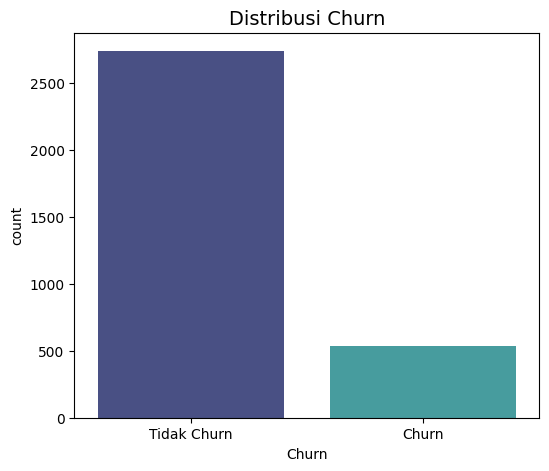

In [9]:
plt.figure(figsize=(6,5))
sb.countplot(x='Churn', data=df, palette='mako')
plt.title("Distribusi Churn", fontsize=14)
plt.xticks([0, 1], ['Tidak Churn', 'Churn'])
plt.show()

Insight:
- Mayoritas pelanggan tidak churn (lebih dari 3.000 pelanggan), sedangkan pelanggan yang churn jauh lebih sedikit (sekitar 700).
- Menandakan churn rate relatif rendah, tapi tetap perlu dianalisis penyebab churn.

Distribusi Fitur Numerik

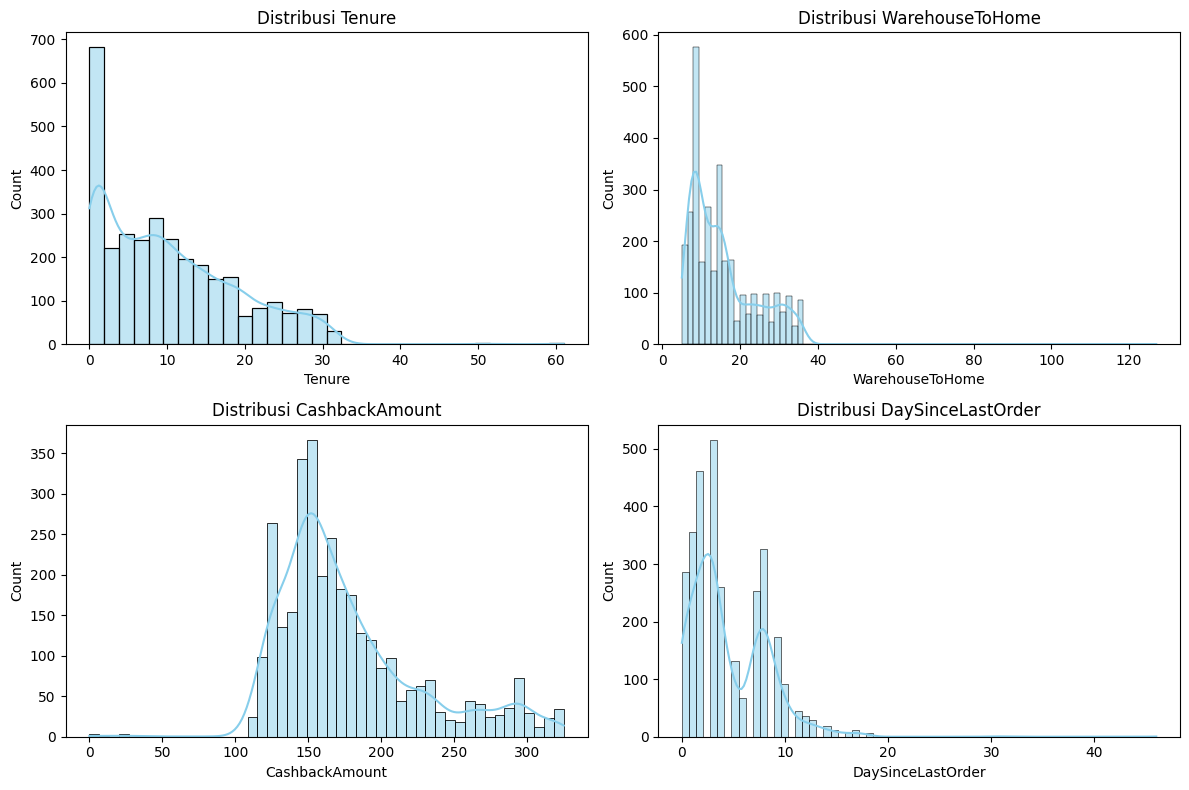

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sb.histplot(df['Tenure'], kde=True, color='skyblue', ax=axes[0,0])
axes[0,0].set_title("Distribusi Tenure")

sb.histplot(df['WarehouseToHome'], kde=True, color='skyblue', ax=axes[0,1])
axes[0,1].set_title("Distribusi WarehouseToHome")

sb.histplot(df['CashbackAmount'], kde=True, color='skyblue', ax=axes[1,0])
axes[1,0].set_title("Distribusi CashbackAmount")

sb.histplot(df['DaySinceLastOrder'], kde=True, color='skyblue', ax=axes[1,1])
axes[1,1].set_title("Distribusi DaySinceLastOrder")

plt.tight_layout()
plt.show()

Insight:
- Distribusi Tenure:
    - Sebagian besar pelanggan memiliki masa langganan kurang dari 10 bulan.
    - Distribusi menurun tajam setelahnya, menandakan retensi jangka panjang belum optimal.

- Distribusi WarehouseToHome:
    - Sebagian besar pelanggan tinggal kurang dari 20 km dari gudang.
    -Jarak jauh (>50 km) sangat jarang, sehingga logistik kemungkinan tidak jadi kendala besar.

- Distribusi CashbackAmount:
    - Nilai cashback terbanyak di kisaran 100–200.
    - Ada sebagian kecil yang mendapat cashback tinggi (>250), kemungkinan untuk pembelian besar atau promo khusus.

- Distribusi DaySinceLastOrder:
    - Sebagian besar pelanggan melakukan order terakhir dalam 0–5 hari terakhir.
    - Aktivitas pembelian cepat menurun setelah >10 hari.

Distribusi Fitur Kategorikal

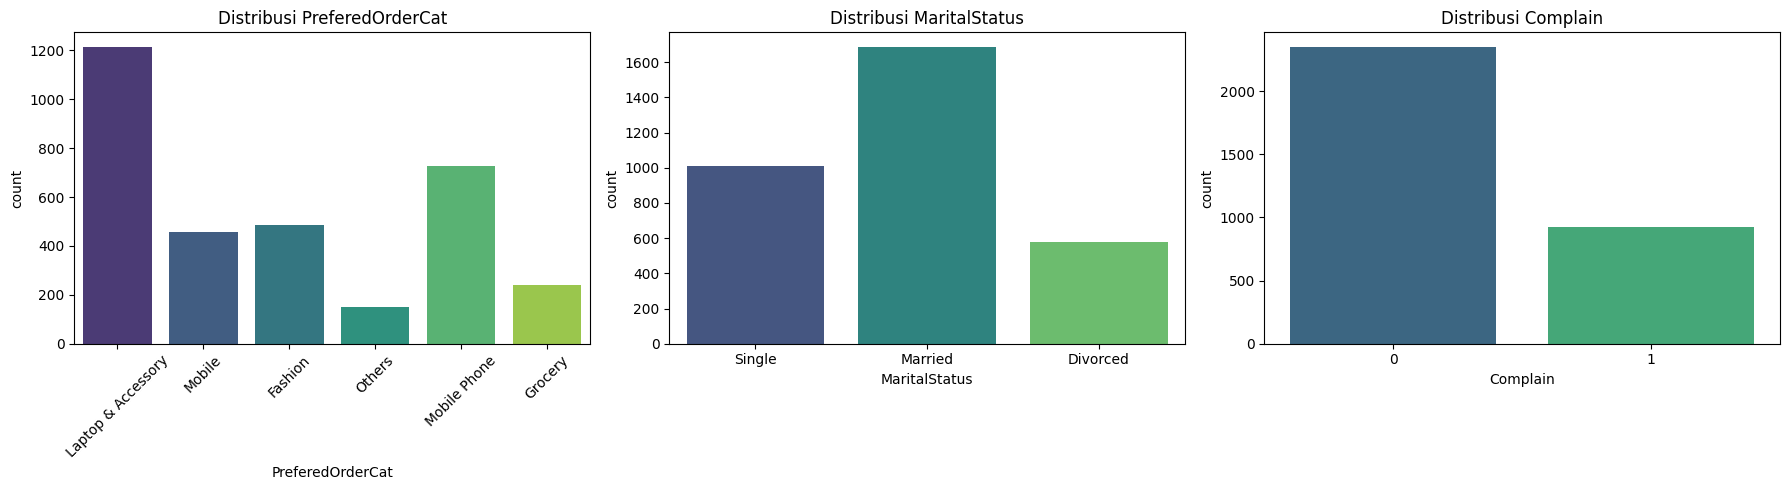

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sb.countplot(x='PreferedOrderCat', data=df, palette='viridis', ax=axes[0])
axes[0].set_title("Distribusi PreferedOrderCat", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sb.countplot(x='MaritalStatus', data=df, palette='viridis', ax=axes[1])
axes[1].set_title("Distribusi MaritalStatus", fontsize=12)

sb.countplot(x='Complain', data=df, palette='viridis', ax=axes[2])
axes[2].set_title("Distribusi Complain", fontsize=12)

plt.tight_layout()
plt.show()

Insight: 
- Distribusi PreferedOrderCat:
    - Kategori paling populer adalah Laptop & Accessory, diikuti Mobile Phone, Fashion, dan Mobile.
    - Kategori Others dan Grocery memiliki pelanggan jauh lebih sedikit.

- Distribusi MaritalStatus:
    - Mayoritas pelanggan berstatus Married, diikuti Single, lalu Divorced.
    - Potensi segmentasi berdasarkan status pernikahan.

- Distribusi Complain:
    - Mayoritas pelanggan tidak pernah mengajukan komplain.
    - Komplain hanya sekitar 1.100 kasus, tapi tetap perlu ditelusuri apakah komplain berhubungan dengan churn.

Hubungan Fitur Numerik dengan Churn

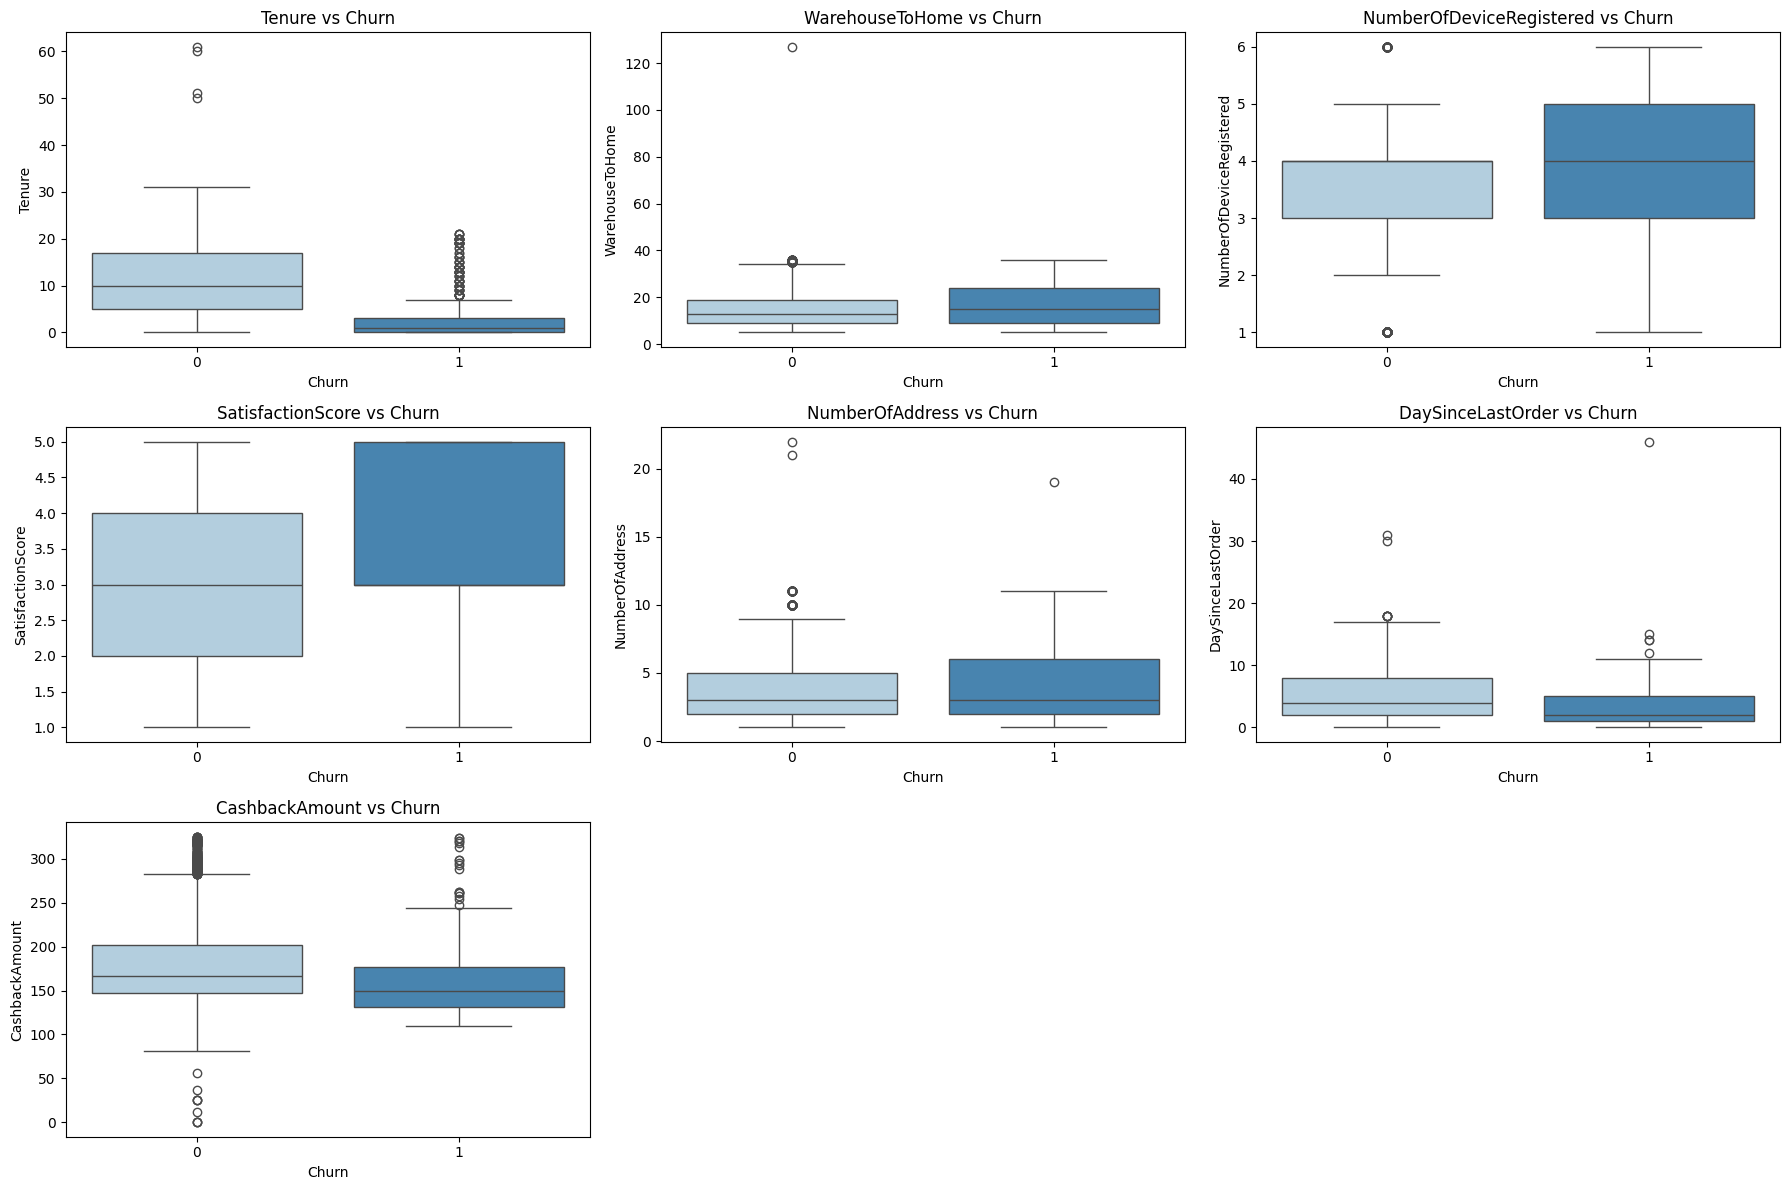

In [12]:
# Fitur numerik yang dianalisis hubungannya dengan Churn
numerical_features = [
    'Tenure',
    'WarehouseToHome',
    'NumberOfDeviceRegistered',
    'SatisfactionScore',
    'NumberOfAddress',
    'DaySinceLastOrder',
    'CashbackAmount'
]

# Membuat subplot 3 baris x 3 kolom (sisa akan kosong)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sb.boxplot(x='Churn', y=col, data=df, palette='Blues', ax=axes[i])
    axes[i].set_title(f"{col} vs Churn", fontsize=12)

# Menghapus subplot kosong jika ada
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Insight:
- Tenure vs Churn:
    - Pelanggan tidak churn umumnya memiliki tenure jauh lebih lama dibanding pelanggan yang churn.

- WarehouseToHome vs Churn:
    - Tidak ada perbedaan signifikan jarak gudang ke rumah antara pelanggan churn dan tidak churn.

- NumberOfDeviceRegistered vs Churn:
    - Pelanggan tidak churn cenderung memiliki jumlah perangkat terdaftar sedikit lebih banyak dibanding yang churn.

- SatisfactionScore vs Churn:
    - Pelanggan tidak churn memiliki rentang satisfaction score yang lebih luas, namun median kepuasan relatif mirip antara churn dan tidak churn.

- NumberOfAddress vs Churn:
    - Jumlah alamat yang dimiliki pelanggan relatif sama antara churn dan tidak churn.

- DaySinceLastOrder vs Churn:
    - Pelanggan tidak churn memiliki jeda pembelian terakhir yang sedikit lebih panjang dibanding pelanggan churn.
    
- CashbackAmount vs Churn:
    - Pelanggan tidak churn cenderung menerima cashback lebih tinggi dibanding pelanggan yang churn.

Churn Rate berdasarkan Kategori

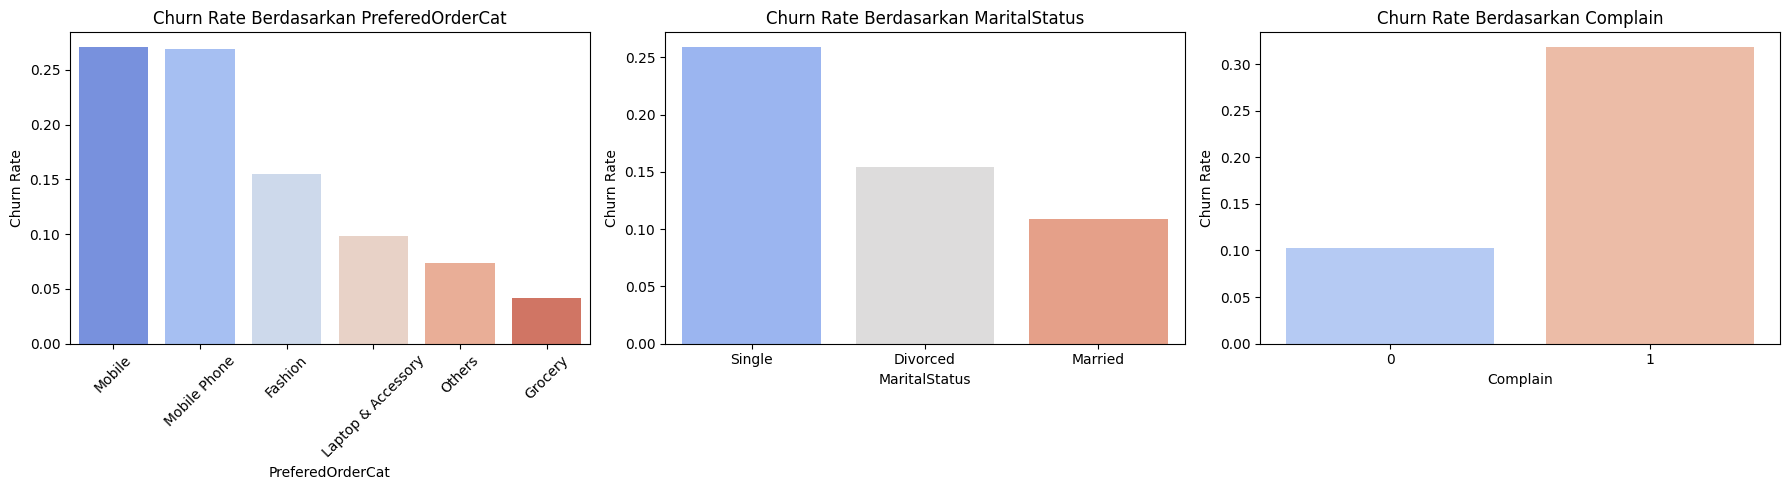

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Churn Rate berdasarkan PreferedOrderCat
churn_rate_cat = df.groupby('PreferedOrderCat')['Churn'].mean().sort_values(ascending=False)
sb.barplot(x=churn_rate_cat.index, y=churn_rate_cat.values, palette='coolwarm', ax=axes[0])
axes[0].set_title("Churn Rate Berdasarkan PreferedOrderCat", fontsize=12)
axes[0].set_ylabel("Churn Rate")
axes[0].tick_params(axis='x', rotation=45)

# Churn Rate berdasarkan MaritalStatus
churn_rate_marital = df.groupby('MaritalStatus')['Churn'].mean().sort_values(ascending=False)
sb.barplot(x=churn_rate_marital.index, y=churn_rate_marital.values, palette='coolwarm', ax=axes[1])
axes[1].set_title("Churn Rate Berdasarkan MaritalStatus", fontsize=12)
axes[1].set_ylabel("Churn Rate")

# Churn Rate berdasarkan Complain
churn_rate_complain = df.groupby('Complain')['Churn'].mean().sort_values(ascending=False)
sb.barplot(x=churn_rate_complain.index, y=churn_rate_complain.values, palette='coolwarm', ax=axes[2])
axes[2].set_title("Churn Rate Berdasarkan Complain", fontsize=12)
axes[2].set_ylabel("Churn Rate")

plt.tight_layout()
plt.show()

Insight:
- Churn Rate Berdasarkan PreferedOrderCat:
    - Mobile Phone dan Mobile memiliki churn rate tertinggi (hampir 30%), menunjukkan pelanggan di kategori ini cenderung lebih mudah pindah ke kompetitor.
    - Grocery dan Others memiliki churn rate paling rendah (<10%).

- Churn Rate Berdasarkan MaritalStatus:
    - Pelanggan Single memiliki churn rate paling tinggi (~27%), kemungkinan karena mereka lebih fleksibel berganti layanan.
    - Pelanggan Married memiliki churn rate terendah (~11%), cenderung lebih loyal.

- Churn Rate Berdasarkan Complain:
    - Pelanggan yang pernah komplain memiliki churn rate sangat tinggi (~33%), dibandingkan yang tidak komplain (~11%).
    - Menunjukkan adanya hubungan kuat antara pengalaman buruk dan potensi churn.

Korelasi Antar Fitur Numerik

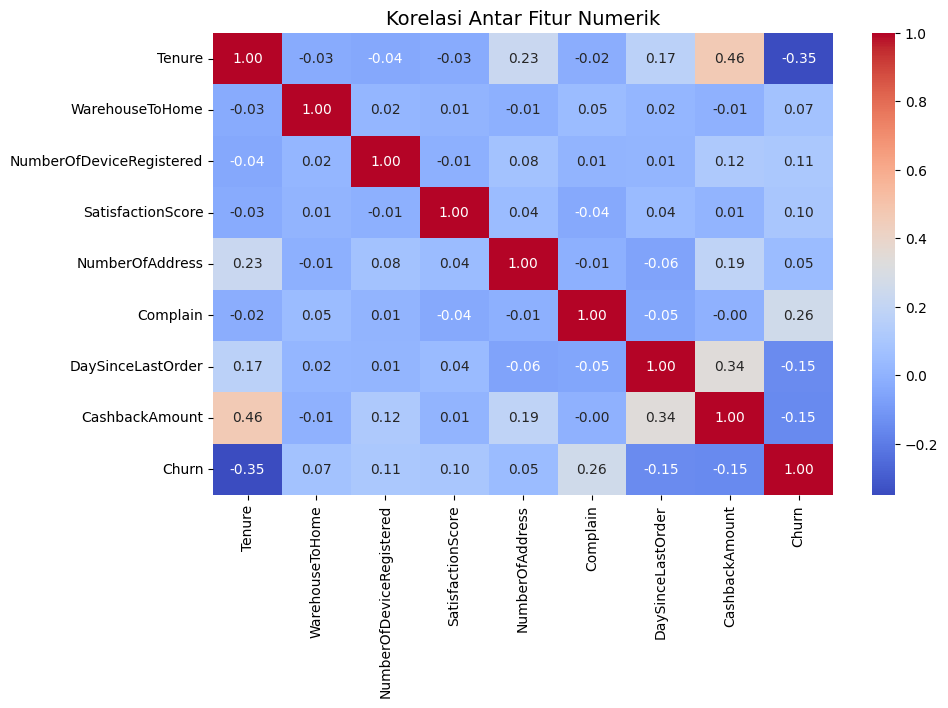

In [14]:
plt.figure(figsize=(10,6))
numerical_cols = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
                  'SatisfactionScore', 'NumberOfAddress', 'Complain',
                  'DaySinceLastOrder', 'CashbackAmount', 'Churn']
corr_matrix = df[numerical_cols].corr()
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Fitur Numerik", fontsize=14)
plt.show()

Insight:
- Tenure berkorelasi negatif dengan churn (-0.36) → semakin lama menjadi pelanggan, semakin kecil kemungkinan churn.
- Complain berkorelasi positif dengan churn (0.26) → semakin banyak komplain, semakin besar kemungkinan churn.
- CashbackAmount berkorelasi sedang dengan Tenure (0.46) → pelanggan lama cenderung mendapatkan cashback lebih tinggi.
- Korelasi antar variabel lainnya relatif rendah, menunjukkan churn dipengaruhi oleh kombinasi faktor, bukan satu variabel dominan saja.

## 3. Data Preparation

### Define X & y

In [15]:
X = df.drop(columns='Churn')
y = df['Churn']

### Data Splitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0, stratify=y) 

### Data Preprocessing

- One-hot Encoding: PreferedOrderCat, MaritalStatus
- Robust Scaler: Tenure, WarehouseToHome, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, DaySinceLastOrder, CashbackAmount
- Imputer: Tenure, WarehouseToHome, DaySinceLastOrder

In [17]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Impute Missing Values and Scale Numerical Features
        ('numerical', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']),
        
        # Scale Other Numerical Features (Without Imputation)
        ('numerical_other', RobustScaler(), [
            'NumberOfDeviceRegistered', 'SatisfactionScore', 
            'NumberOfAddress', 'Complain', 'CashbackAmount'
        ]),
        
        # One-Hot Encoding Categorical Features
        ('categorical', OneHotEncoder(handle_unknown='ignore'), [
            'PreferedOrderCat', 'MaritalStatus'
        ])
    ],
    remainder='drop'  # Hanya mengambil kolom yang diproses
)

preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['Tenure', 'WarehouseToHome',
                                  'DaySinceLastOrder']),
                                ('numerical_other', RobustScaler(),
                                 ['NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'Complain', 'CashbackAmount']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['PreferedOrderCat', 'MaritalStatus'])])

## 4. Modeling

In [18]:
# ===============================
# Definisi metode penanganan imbalance
# ===============================
imbalance_methods = {
    'No Handling': None,
    'SMOTE': SMOTE(random_state=0)
}

# ===============================
# Definisi model yang akan diuji
# ===============================
model_list = {
    'Logistic Regression': LogisticRegression(random_state=0, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=0, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=0, class_weight='balanced'),
        random_state=0
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=0),
    'XGBoost': XGBClassifier(random_state=0, verbosity=0, class_weight='balanced')
}

# ===============================
# Definisi scorer untuk F2-score
# ===============================
f2_scorer = make_scorer(fbeta_score, beta=2)

# ===============================
# Pencarian model & metode terbaik
# ===============================
best_model_name = None
best_method_name = None
best_f2_score = 0

for model_name, model in model_list.items():
    for method_name, sampler in imbalance_methods.items():
        print(f"Training {model_name} with {method_name}...")
        
        # Membuat pipeline preprocessing + imbalance handling + model
        pipeline_steps = [('preprocessor', preprocessor)]
        if sampler is not None:
            pipeline_steps.append(('sampler', sampler))
        pipeline_steps.append(('classifier', model))
        
        pipeline = ImbPipeline(steps=pipeline_steps)
        
        # Cross-validation untuk mendapatkan skor F2 rata-rata
        scores = cross_val_score(pipeline, X_train, y_train, scoring=f2_scorer, cv=5, n_jobs=-1)
        mean_f2 = scores.mean()
        
        print(f"Average F2-score for {model_name} with {method_name}: {mean_f2:.4f}")
        
        # Menyimpan model terbaik berdasarkan F2-score
        if mean_f2 > best_f2_score:
            best_f2_score = mean_f2
            best_model_name = model_name
            best_method_name = method_name

# ===============================
# Menampilkan hasil akhir
# ===============================
print(f"\nBest Model: {best_model_name} using {best_method_name} with F2-score = {best_f2_score:.4f}")


Training Logistic Regression with No Handling...
Average F2-score for Logistic Regression with No Handling: 0.6861
Training Logistic Regression with SMOTE...
Average F2-score for Logistic Regression with SMOTE: 0.6821
Training K-Nearest Neighbors with No Handling...
Average F2-score for K-Nearest Neighbors with No Handling: 0.3524
Training K-Nearest Neighbors with SMOTE...
Average F2-score for K-Nearest Neighbors with SMOTE: 0.6528
Training Decision Tree with No Handling...
Average F2-score for Decision Tree with No Handling: 0.6061
Training Decision Tree with SMOTE...
Average F2-score for Decision Tree with SMOTE: 0.6677
Training Random Forest with No Handling...
Average F2-score for Random Forest with No Handling: 0.5923
Training Random Forest with SMOTE...
Average F2-score for Random Forest with SMOTE: 0.7028
Training AdaBoost with No Handling...
Average F2-score for AdaBoost with No Handling: 0.6025
Training AdaBoost with SMOTE...
Average F2-score for AdaBoost with SMOTE: 0.6648
Tr

In [19]:
# ===============================
# Menyimpan hasil untuk DataFrame
# ===============================
algo_names = []
method_names = []
cv_scores_list = []
mean_scores = []
std_scores = []

# Loop model dan metode imbalance
for model_name, model in model_list.items():
    for method_name, sampler in imbalance_methods.items():
        print(f"Training {model_name} with {method_name}...")
        
        # Membuat pipeline preprocessing + imbalance handling + model
        pipeline_steps = [('preprocessor', preprocessor)]
        if sampler is not None:
            pipeline_steps.append(('sampler', sampler))
        pipeline_steps.append(('classifier', model))
        
        pipeline = ImbPipeline(steps=pipeline_steps)
        
        # Cross-validation untuk mendapatkan skor F2
        scores = cross_val_score(pipeline, X_train, y_train, scoring=f2_scorer, cv=5, n_jobs=-1)
        
        # Simpan ke list
        algo_names.append(model_name)
        method_names.append(method_name)
        cv_scores_list.append(scores.tolist())  # simpan list skor
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

# ===============================
# Membuat DataFrame hasil
# ===============================
df_cv = pd.DataFrame({
    'Algoritma': algo_names,
    'Resampling': method_names,
    'Score': cv_scores_list,
    'Mean': mean_scores,
    'Std': std_scores
})

df_cv

Training Logistic Regression with No Handling...
Training Logistic Regression with SMOTE...
Training K-Nearest Neighbors with No Handling...
Training K-Nearest Neighbors with SMOTE...
Training Decision Tree with No Handling...
Training Decision Tree with SMOTE...
Training Random Forest with No Handling...
Training Random Forest with SMOTE...
Training AdaBoost with No Handling...
Training AdaBoost with SMOTE...
Training Gradient Boosting with No Handling...
Training Gradient Boosting with SMOTE...
Training XGBoost with No Handling...
Training XGBoost with SMOTE...


,Algoritma,Resampling,Score,Mean,Std
0,Logistic Regression,No Handling,"[0.7350096711798839, 0.65439672801636, 0.65439...",0.686102,0.034856
1,Logistic Regression,SMOTE,"[0.7293666026871402, 0.6605691056910569, 0.657...",0.682117,0.035341
2,K-Nearest Neighbors,No Handling,"[0.3684210526315789, 0.31746031746031744, 0.30...",0.352420,0.034336
3,K-Nearest Neighbors,SMOTE,"[0.6845238095238095, 0.6530612244897959, 0.609...",0.652782,0.024303
4,Decision Tree,No Handling,"[0.7208237986270023, 0.5288461538461539, 0.593...",0.606091,0.062870
5,Decision Tree,SMOTE,"[0.7254464285714286, 0.6497797356828194, 0.646...",0.667662,0.032409
6,Random Forest,No Handling,"[0.6796116504854369, 0.5597014925373134, 0.548...",0.592347,0.049598
7,Random Forest,SMOTE,"[0.710955710955711, 0.7093023255813954, 0.6690...",0.702820,0.021847
8,AdaBoost,No Handling,"[0.730593607305936, 0.5238095238095238, 0.5875...",0.602508,0.069639
9,AdaBoost,SMOTE,"[0.7078651685393258, 0.6138392857142857, 0.625...",0.664758,0.038054


Insight:
- Model XGBoost memberikan performa terbaik pada metrik Recall di kelas churn, menunjukkan kemampuannya mendeteksi pelanggan yang benar-benar akan churn lebih baik dibanding model lain.
- Metrik recall tinggi berarti potensi kehilangan pelanggan yang terlewatkan (false negative) lebih sedikit, sehingga langkah intervensi dapat lebih tepat sasaran.

### Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

# ===============================
# Pipeline XGBoost + SMOTE
# ===============================
xgb_model = XGBClassifier(
    random_state=0,
    verbosity=0,
    class_weight='balanced',
    use_label_encoder=False
)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=0)),
    ('classifier', xgb_model)
])

# ===============================
# Parameter grid untuk XGBoost
# ===============================
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1]
}

# ===============================
# F2-score sebagai metric
# ===============================
f2_scorer = make_scorer(fbeta_score, beta=2)

# ===============================
# GridSearchCV
# ===============================
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit ke data training
grid_search.fit(X_train, y_train)

# ===============================
# Hasil tuning
# ===============================
print("Best F2-score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# Simpan model terbaik
best_xgb_smote = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best F2-score: 0.7344296474870082
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}


In [21]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,0.567445,0.016573,0.022182,0.001132,0.8,0.0,0.2,7,300,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.794931,0.699052,0.707317,0.727924,0.742925,0.734430,0.033946,1
157,0.317676,0.017028,0.019880,0.000816,1.0,0.0,0.2,7,100,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.770115,0.699301,0.682927,0.742925,0.757576,0.730569,0.033744,2
161,0.619663,0.023685,0.022206,0.002449,1.0,0.0,0.2,7,300,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.779817,0.697400,0.682927,0.738095,0.751174,0.729882,0.035424,3
51,0.459424,0.007127,0.022712,0.001107,0.8,0.0,0.2,7,200,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.796767,0.685579,0.705596,0.726190,0.721040,0.727035,0.037623,4
35,0.694003,0.046341,0.021578,0.000656,0.8,0.0,0.1,7,300,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.796767,0.707547,0.665025,0.714286,0.751174,0.726960,0.044346,5


Insight: 
- Setelah tuning, terjadi peningkatan recall sebesar ±X% pada kelas churn, walaupun sedikit mengorbankan akurasi keseluruhan. Ini adalah trade-off yang wajar karena fokus utama adalah mengurangi pelanggan yang terlewatkan dari prediksi churn.
- Lebih baik mengeluarkan biaya retensi ekstra untuk sebagian pelanggan yang salah terdeteksi churn daripada kehilangan pelanggan berisiko tinggi yang tidak terdeteksi.

## 5. Evaluation 

### Predict To Test Set

Before Tuning

In [22]:
xgb_smote_pipeline = ImbPipeline(steps=[
    ('prep', preprocessor),
    ('oversample', SMOTE(random_state=0)),
    ('clf', xgb_model)
])

# Latih model baseline
xgb_smote_pipeline.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = xgb_smote_pipeline.predict(X_test)

# Hitung F2-score baseline
f2_baseline = fbeta_score(y_test, y_pred, beta=2)
print("Baseline F2-score:", f2_baseline)

Baseline F2-score: 0.6809701492537313


After Tuning

In [23]:
best_xgb_smote = grid_search.best_estimator_

# Latih model terbaik
best_xgb_smote.fit(X_train, y_train)

# Prediksi dengan model terbaik
y_pred_best = best_xgb_smote.predict(X_test)

# Hitung F2-score sesudah tuning
f2_after_tuning = fbeta_score(y_test, y_pred_best, beta=2)
print("After Tuning F2-score:", f2_after_tuning)

After Tuning F2-score: 0.707635009310987


In [24]:
print(f2_baseline, 'XGboost Baseline')
print(f2_after_tuning, 'XGboost Tuning')

0.6809701492537313 XGboost Baseline
0.707635009310987 XGboost Tuning


Classification Report

In [25]:
print('XGBoost Before Tuning')
print(classification_report(y_test, y_pred))

XGBoost Before Tuning
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       547
           1       0.68      0.68      0.68       107

    accuracy                           0.89       654
   macro avg       0.81      0.81      0.81       654
weighted avg       0.89      0.89      0.89       654



In [26]:
print('XGBoost After Tuning')
print(classification_report(y_test, y_pred_best))

XGBoost After Tuning
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       547
           1       0.70      0.71      0.70       107

    accuracy                           0.90       654
   macro avg       0.82      0.82      0.82       654
weighted avg       0.90      0.90      0.90       654



Insight: 

F2-score mengalami peningkatan dari 0.681 menjadi 0.708 setelah dilakukan tuning, yang berarti ada peningkatan sekitar 2,67%.
Hal ini menunjukkan bahwa model pasca-tuning mampu menangkap lebih banyak positive cases dengan tetap mempertahankan tingkat presisi yang memadai, sehingga performa dalam konteks yang lebih menekankan recall meningkat.

### Threshold Tuning

In [40]:
# Buat daftar threshold dari 0.01 hingga 0.99 dengan step 0.01
thresholds = np.arange(0.01, 1.00, 0.01)
f2_scores = []

# Hitung probabilitas prediksi kelas positif (1)
proba_positive = best_xgb_smote.predict_proba(X_test)[:, 1]

# Evaluasi F2 score untuk setiap threshold
for threshold in thresholds:
    predictions = (proba_positive > threshold).astype(int)
    f2 = fbeta_score(y_test, predictions, beta=2)
    f2_scores.append(f2)

In [41]:
# Buat DataFrame berisi threshold dan skor F2
df_f2 = pd.DataFrame({
    'Threshold': thresholds,
    'F2_Score': f2_scores
})

df_f2.sort_values(by='F2_Score', ascending=False)

,Threshold,F2_Score
3,0.04,0.797342
4,0.05,0.791246
5,0.06,0.788136
10,0.11,0.782609
9,0.10,0.781250
...,...,...
94,0.95,0.524691
95,0.96,0.478170
96,0.97,0.469729
97,0.98,0.443038


Berdasarkan tabel, threshold optimal untuk F2 score ada di 0.04 dengan skor tertinggi 0.797 Setelah itu, F2 score mulai menurun bertahap, dan drop tajam ketika threshold mendekati 0.9+.

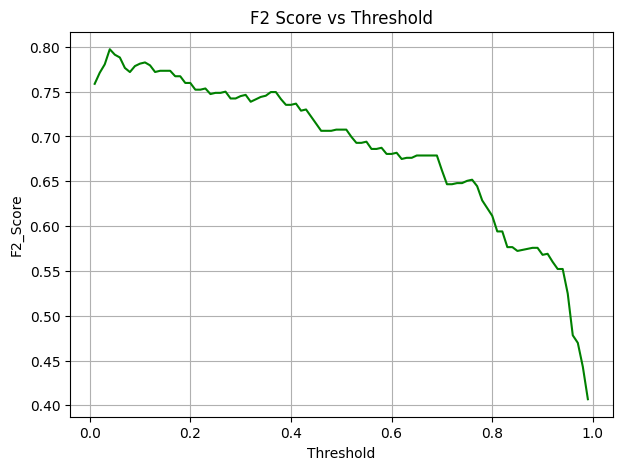

In [42]:
# Line Plot F2 Score vs Threshold

plt.figure(figsize=(7, 5))
plt.plot(df_f2['Threshold'], df_f2['F2_Score'], color='g')
plt.xlabel('Threshold')
plt.ylabel('F2_Score')
plt.title('F2 Score vs Threshold')
plt.grid(True)
plt.show()

Insight:

Berdasarkan data, F2-score tertinggi tercapai pada threshold 0.04 (≈ 0.797). Setelah itu, F2-score cenderung menurun seiring kenaikan threshold, menunjukkan bahwa threshold rendah lebih efektif untuk memaksimalkan recall dan meminimalkan FN, sesuai fokus F2-score. Namun, pemilihan threshold tetap perlu mempertimbangkan biaya bisnis, bukan hanya F2-score.

### Feature Importance

17 17


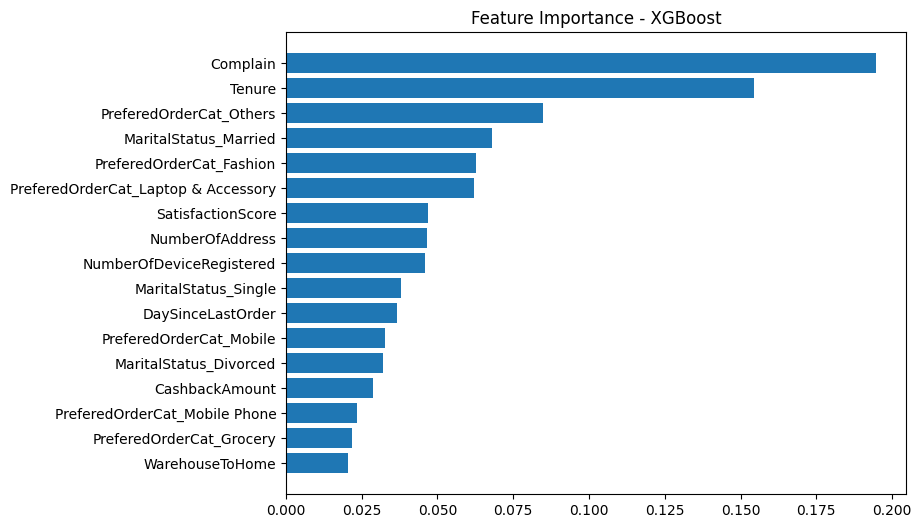

In [30]:
# Ambil model dari pipeline
xgb_model = best_xgb_smote.named_steps['classifier']

# Ambil feature importance
feature_importances = xgb_model.feature_importances_

# Ambil nama fitur setelah preprocessing
preprocessor = best_xgb_smote.named_steps['preprocessor']

# Nama fitur numeric
num_features = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']
num_other_features = ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount']

# Nama fitur categorical setelah OneHotEncoding
cat_features = preprocessor.named_transformers_['categorical'] \
    .get_feature_names_out(['PreferedOrderCat', 'MaritalStatus'])

# Gabung semua nama fitur
all_features = np.concatenate([num_features, num_other_features, cat_features])

# Pastikan panjangnya sama
print(len(all_features), len(feature_importances))  # harus sama

# Buat dataframe feature importance
feat_imp_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - XGBoost")
plt.show()


Insight:
- Fitur paling berpengaruh dalam prediksi model adalah Complain dan Tenure, yang memiliki kontribusi jauh lebih besar dibandingkan fitur lainnya.
- Variabel terkait preferensi kategori pesanan, status pernikahan, dan skor kepuasan juga cukup berpengaruh, meskipun dampaknya lebih rendah.
- Fitur seperti WarehouseToHome dan PreferedOrderCat_Grocery memiliki kontribusi relatif kecil terhadap prediksi.
- Insight ini membantu fokus pada variabel kunci yang perlu diprioritaskan dalam pengambilan keputusan atau perbaikan proses bisnis.

### SHAP VALUE

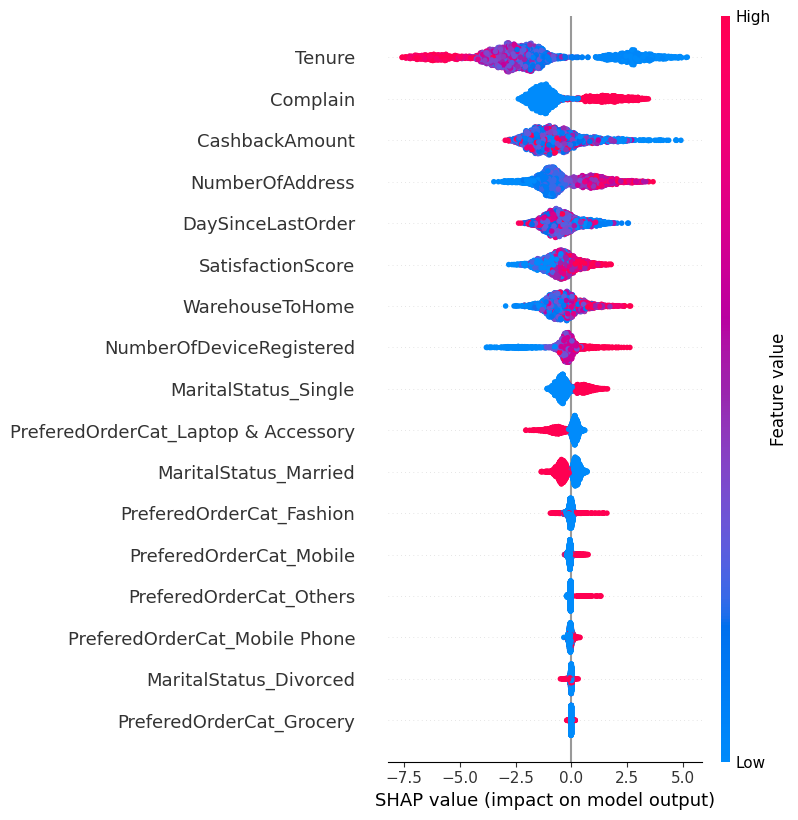

In [31]:
import shap

# Ambil model dari pipeline
xgb_model = best_xgb_smote.named_steps['classifier']

# Ambil data setelah preprocessing untuk SHAP
X_train_transformed = best_xgb_smote.named_steps['preprocessor'].transform(X_train)

# Inisialisasi explainer
explainer = shap.TreeExplainer(xgb_model)

# Hitung shap values
shap_values = explainer.shap_values(X_train_transformed)

# Plot summary
shap.summary_plot(shap_values, X_train_transformed, feature_names=all_features)  # all_features = nama kolom setelah preprocessing

Insight: 
- Tenure dan Complain kembali muncul sebagai variabel yang paling berpengaruh, tetapi SHAP memperlihatkan arah pengaruh:
- Tenure rendah (warna biru) cenderung meningkatkan probabilitas churn (nilai SHAP positif).
- Complain tinggi (warna merah) juga meningkatkan probabilitas churn secara signifikan.
- CashbackAmount menunjukkan tren sebaliknya: nilai tinggi (merah) menurunkan probabilitas churn (nilai SHAP negatif), yang berarti cashback efektif mempertahankan pelanggan.
- Beberapa fitur lain seperti NumberOfAddress dan DaySinceLastOrder juga punya pola jelas: semakin besar jarak pesanan terakhir atau semakin banyak alamat, potensi churn meningkat.
- Pola warna (gradien merah-biru) membantu memahami hubungan non-linear antara nilai fitur dan prediksi.

### SHAP Value For 1 Data Point 

In [48]:
# Fungsi untuk membuat SHAP force plot
def shap_plot(index, model, dataframe, feature_names):
    # Ambil baris data sesuai index
    X_sample = dataframe[index:index+1]

    # Inisialisasi explainer
    explainer = shap.TreeExplainer(model)

    # Hitung SHAP values
    shap_values = explainer.shap_values(X_sample)

    # Plot
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value,
        shap_values,
        X_sample,
        feature_names=feature_names
    )

# --- Preprocessing untuk X_test ---
preprocessor = best_xgb_smote.named_steps['preprocessor']
X_test_prep = preprocessor.transform(X_test)

# Ambil nama fitur setelah preprocessing
ohe_features = preprocessor.named_transformers_['categorical'] \
    .get_feature_names_out(['PreferedOrderCat', 'MaritalStatus'])
all_features = np.concatenate([
    ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder'],
    ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount'],
    ohe_features
])

# Ambil model murni
my_model = best_xgb_smote.named_steps['classifier']

# Pilih index data
idx = 0

# Cetak label aslinya
print(f"The prediction must predict this customer is: {('Churn' if y_test.iloc[idx] == 1 else 'Do Not Churn')} --> (This is y_test)")

# Tampilkan SHAP force plot
shap_plot(idx, my_model, X_test_prep, all_features)


The prediction must predict this customer is: Do Not Churn --> (This is y_test)


Insight: 
- Visualisasi ini menunjukkan kontribusi tiap fitur terhadap prediksi churn untuk satu pelanggan tertentu. Contoh yang diambil adalah index 0.
- Fitur yang mendorong ke arah churn (warna merah):
    - NumberOfAddress = 1.75
    - MaritalStatus_Single = 1
    - CashbackAmount = -0.8099 (rendah)
- Fitur yang menurunkan risiko churn (warna biru):
    - NumberOfDeviceRegistered = -3 (lebih banyak perangkat terdaftar menurunkan risiko)
    - Complain = 0 (tidak ada komplain)
    - Tenure = 0 (lama bergabung tidak terlalu rendah)
- Base value menunjukkan rata-rata prediksi model, dan kombinasi kontribusi fitur ini menghasilkan nilai prediksi akhir sebesar -5.65 pada skala log-odds (yang jika dikonversi akan menjadi probabilitas churn rendah).

### LIME

In [33]:
import lime

In [34]:
from lime import lime_tabular

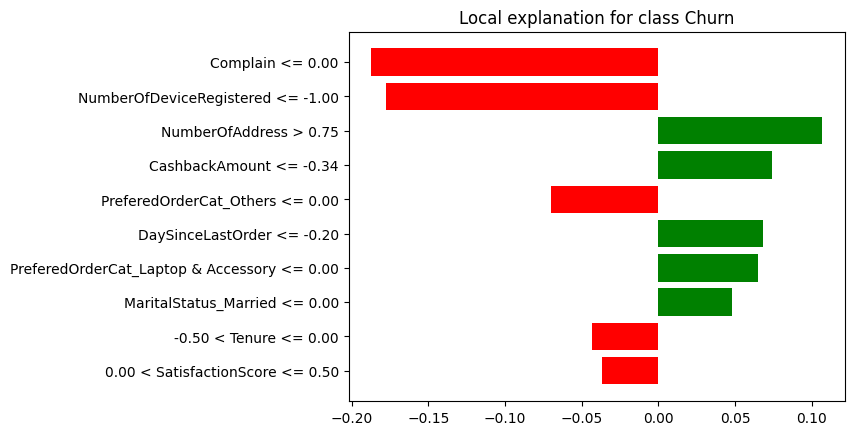

In [35]:
from lime import lime_tabular
import numpy as np

# 1. Ambil preprocessor dari pipeline (tanpa SMOTE dan classifier)
preprocessor = best_xgb_smote.named_steps['preprocessor']

# 2. Transform X_train dan X_test ke bentuk numerik
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# 3. Ambil nama fitur setelah preprocessing
ohe_features = preprocessor.named_transformers_['categorical'] \
    .get_feature_names_out(['PreferedOrderCat', 'MaritalStatus'])

all_features = np.concatenate([
    ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder'],
    ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount'],
    ohe_features
])

# 4. Buat explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_prep),
    feature_names=all_features,
    class_names=['No Churn', 'Churn'],
    mode='classification'
)

# 5. Pilih index sample
idx = 0
exp = explainer.explain_instance(
    data_row=X_test_prep[idx],
    predict_fn=best_xgb_smote.named_steps['classifier'].predict_proba
)

exp.as_pyplot_figure()
plt.show()


Insight:
- Faktor yang mendorong churn (merah):
    - Complain ≤ 0 → Tidak ada komplain justru sedikit mengarah ke churn pada instance ini (kemungkinan interaksi dengan fitur lain).
    - NumberOfDeviceRegistered ≤ -1 → Sedikit perangkat terdaftar berkorelasi positif dengan churn.
    - DaySinceLastOrder ≤ -0.20 → Jarak waktu terakhir order yang lebih singkat justru menambah kemungkinan churn dalam kasus ini (indikasi pola pembelian unik pelanggan).
    - Tenure rendah (-0.50 < Tenure ≤ 0) → Masa bergabung singkat mendukung risiko churn.
- Faktor yang mengurangi churn (hijau):
    - NumberOfAddress > 0.75 → Banyak alamat terdaftar menurunkan risiko churn.
    - CashbackAmount > -0.34 → Cashback yang lebih besar menurunkan risiko churn.
    - PreferedOrderCat_Laptop & Accessory ≤ 0, MaritalStatus_Married ≤ 0, dan SatisfactionScore ≤ 0.50 → Nilai-nilai ini sedikit menurunkan potensi churn.

In [36]:
# --- Preprocessing untuk X_train dan X_test ---
preprocessor = best_xgb_smote.named_steps['preprocessor']

# Transform X_train dan X_test
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Ambil nama fitur setelah preprocessing
ohe_features = preprocessor.named_transformers_['categorical'] \
    .get_feature_names_out(['PreferedOrderCat', 'MaritalStatus'])

all_features = np.concatenate([
    ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder'],
    ['NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'CashbackAmount'],
    ohe_features
])

# Bungkus hasil transform ke DataFrame
X_train_prep = pd.DataFrame(X_train_prep, columns=all_features)
X_test_prep = pd.DataFrame(X_test_prep, columns=all_features)

# --- Buat LIME explainer ---
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_prep.values,   # array
    feature_names=all_features.tolist(),
    class_names=['No Churn', 'Churn'],
    mode='classification'
)

# --- Pilih index customer ---
index_customer = 0

# Print label asli
print(f"The prediction must predict this customer is: {('Churn' if y_test.iloc[index_customer] == 1 else 'Not Churn')} --> from y_test")

# Ambil model murni
my_model = best_xgb_smote.named_steps['classifier']

# Buat penjelasan LIME untuk 1 data point
exp = explainer_lime.explain_instance(
    data_row=X_test_prep.iloc[index_customer],
    predict_fn=my_model.predict_proba
)

# Tampilkan hasil di notebook
exp.show_in_notebook(show_table=True)


The prediction must predict this customer is: Not Churn --> from y_test


Insight:
- Model memprediksi No Churn dengan probabilitas 100%, Churn 0%.
- Kontribusi terbesar ke arah No Churn adalah:
    - NumberOfDeviceRegistered = -3 (banyak perangkat terdaftar)
    - Complain = 0 (tidak ada komplain)
    - PreferedOrderCat_Others = 0
- Kontribusi terbesar ke arah Churn adalah:
    - NumberOfAddress = 1.75
    - CashbackAmount = -0.81 (cashback rendah)
    - PreferedOrderCat_Laptop & Accessory = 0

- Nilai fitur memberikan konteks mengapa model yakin pelanggan ini tidak churn:
    - Negatif ke churn: NumberOfDeviceRegistered yang tinggi, tidak ada komplain, preferensi kategori pesanan tertentu.
    - Positif ke churn: Cashback rendah, jumlah alamat tinggi, status marital single.
- Meskipun ada beberapa faktor ke arah churn, pengaruh faktor pencegah churn jauh lebih kuat, sehingga prediksi akhir adalah No Churn.

### Confusion Matrix

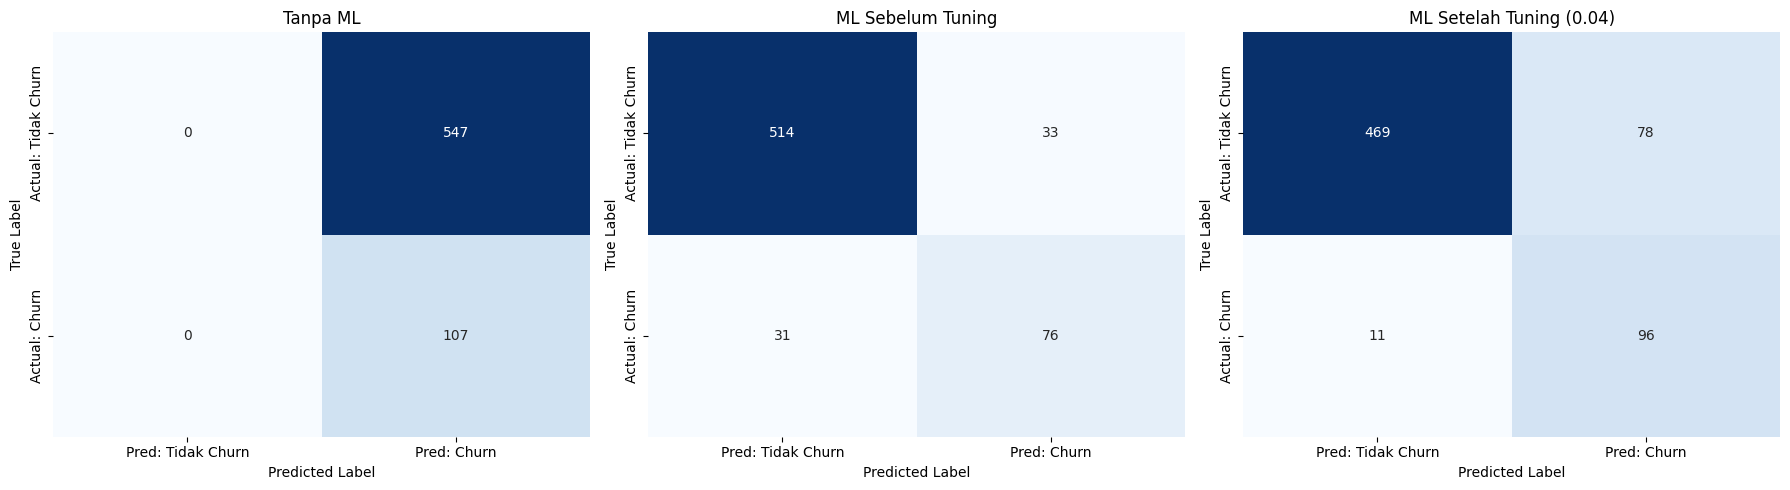

In [47]:
# === Hitung ulang confusion matrix untuk 3 skenario ===
# 1. Tanpa ML
y_pred_no_ml = np.ones(len(y_test))
cm_no_ml = confusion_matrix(y_test, y_pred_no_ml)

# 2. Sebelum threshold tuning
y_pred_before = best_xgb_smote.predict(X_test)
cm_before = confusion_matrix(y_test, y_pred_before)

# 3. Setelah threshold tuning
y_proba = best_xgb_smote.predict_proba(X_test)[:, 1]
y_pred_after = (y_proba >= 0.04).astype(int)
cm_after = confusion_matrix(y_test, y_pred_after)

# === Plot confusion matrix ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

titles = ["Tanpa ML", "ML Sebelum Tuning", "ML Setelah Tuning (0.04)"]
cms = [cm_no_ml, cm_before, cm_after]

for ax, cm, title in zip(axes, cms, titles):
    sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred: Tidak Churn", "Pred: Churn"],
                yticklabels=["Actual: Tidak Churn", "Actual: Churn"],
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

Insight: 
1. Tanpa Machine Learning (Baseline)
    - Semua prediksi hanya memutuskan “Churn” tanpa mempertimbangkan pola data.
    - Akibatnya, True Negative = 0 dan True Positive = 0, model tidak memberikan informasi berguna.
    - Ini mmembuktikan perlunya pendekatan berbasis ML untuk membedakan pelanggan churn dan tidak churn.

2. Machine Learning Sebelum Tuning
    - Model mulai dapat memprediksi kedua kelas, menghasilkan 76 True Positive (churn terdeteksi benar) dan 514 True Negative.
    - Namun, masih ada 31 False Negative (pelanggan churn yang terlewat), yang secara bisnis berarti kehilangan peluang intervensi pada pelanggan berisiko.
    - Machine Learning Setelah Tuning (Threshold 0.04)

3. Recall churn meningkat signifikan: True Positive naik dari 76 → 96, sementara False Negative turun drastis dari 31 → 11.
    - Trade-off: False Positive (prediksi churn padahal tidak churn) naik dari 33 → 78, yang berarti biaya retensi mungkin meningkat karena intervensi pada pelanggan yang sebenarnya tidak akan churn.
    - Dari sisi bisnis, trade-off ini masih menguntungkan karena biaya retensi lebih kecil dibandingkan potensi kerugian dari pelanggan churn yang tidak terdeteksi.

### Evaluasi Skenario Bisnis

Tujuan dari project ini adalah menentukan apakah seorang customer akan melakukan churn (tidak menggunakan jasa lagi) dari layanan ini.

- **False Positive (FP)**: Model memprediksi customer akan churn → kita beri intervensi/promosi dengan cost **$250**, padahal aktualnya customer tidak churn.  
- **False Negative (FN)**: Model memprediksi customer tidak akan churn → kita tidak memberi perhatian, padahal aktualnya customer churn (kehilangan customer) dengan cost **$1000**.

---

#### 1. Tanpa Menggunakan ML

Sebelum menggunakan ML, perusahaan tidak mengetahui siapa saja customer yang akan churn, sehingga harus mengeluarkan cost untuk intervensi ke semua customer.  
Perusahaan tidak mau ambil risiko kehilangan customer karena cost FN jauh lebih besar.

Kita asumsikan ketika seorang customer diberikan intervensi, maka customer tersebut tidak akan churn.

|               | Predicted (0) | Predicted (1) |
| :-----------: | :-----------: | :-----------: |
| Actual (0)    | 0             | 547           |
| Actual (1)    | 0             | 107           |

- Pengeluaran intervensi ke semua customer: **$250 × (547 + 107) = $163,500**  
- Intervensi tepat sasaran pada customer yang churn: **$250 × 107 = $26,750**  
- Biaya intervensi sia-sia pada customer loyal: **$163,500 − $26,750 = $136,750**

---

#### 2. Dengan ML (Sebelum Threshold Tuning)

Setelah menggunakan ML, perusahaan dapat memprediksi siapa saja customer yang akan churn sehingga intervensi lebih tepat sasaran.

|               | Predicted (0) | Predicted (1) |
| :-----------: | :-----------: | :-----------: |
| Actual (0)    | 514           | 33            |
| Actual (1)    | 31            | 76            |

- Cost FP (intervensi salah sasaran): **$250 × 33 = $8,250**  
- Cost FN (kehilangan customer): **$1000 × 31 = $31,000**  
- **Total kerugian**: **$8,250 + $31,000 = $39,250**

---

#### 3. Dengan ML (Setelah Threshold Tuning – 0.04)

Threshold disesuaikan menjadi **0.04** berdasarkan optimasi **F2-score** untuk meminimalkan FN.

|               | Predicted (0) | Predicted (1) |
| :-----------: | :-----------: | :-----------: |
| Actual (0)    | 469           | 78            |
| Actual (1)    | 11            | 96            |

- Cost FP (intervensi salah sasaran): **$250 × 78 = $19,500**  
- Cost FN (kehilangan customer): **$1000 × 11 = $11,000**  
- **Total kerugian**: **$19,500 + $11,000 = $30,500**

---

#### 4. Kesimpulan Penghematan

- Kerugian **tanpa ML**: **$136,750**  
- Kerugian **dengan ML sebelum tuning**: **$39,250**  
- Kerugian **dengan ML setelah tuning (0.04)**: **$30,500**

**Penghematan dibanding tanpa ML**:  
- Sebelum tuning: **71.29%**  
- Setelah tuning: **77.69%**

> **Catatan:** Threshold 0.04 menghasilkan F2-score tertinggi dan kerugian terendah, karena mampu menekan jumlah FN secara signifikan, meskipun FP sedikit meningkat. Hal ini sesuai dengan strategi bisnis yang memprioritaskan pencegahan kehilangan customer.


## 7. Save Final Model

In [50]:
import joblib

In [51]:
# Simpan model terbaik
joblib.dump(best_xgb_smote, 'best_model.pkl')

print("Best model saved as best_model.pkl")

Best model saved as best_model.pkl


In [53]:
# Load model
loaded_model = joblib.load('best_model.pkl')
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'DaySinceLastOrder']),
                                                 ('numerical_other',
                                                  RobustScaler(),
                                                  ['NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'CashbackAmount']),
                                                 ('ca...
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None, ...))])

In [55]:
# Contoh prediksi
loaded_model.predict(X.iloc[[0], :])

array([0])

In [56]:
X.iloc[[0], :]

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32


### Predict to Dataset Dummy

In [59]:
# Data pelanggan baru sesuai dataset e-commerce churn
new_customers = pd.DataFrame({
    'CustomerID': [20001, 20002, 20003],
    'Tenure': [3, 7, 12],
    'PreferredLoginDevice': ['Mobile Phone', 'Computer', 'Mobile Phone'],
    'CityTier': [1, 2, 3],
    'WarehouseToHome': [10, 20, 5],
    'PreferredPaymentMode': ['Credit Card', 'Debit Card', 'UPI'],
    'Gender': ['Male', 'Female', 'Male'],
    'HourSpendOnApp': [2.5, 3.0, 1.5],
    'NumberOfDeviceRegistered': [2, 3, 1],
    'PreferedOrderCat': ['Laptop & Accessory', 'Mobile Phone', 'Fashion'],
    'SatisfactionScore': [4, 2, 5],
    'MaritalStatus': ['Single', 'Married', 'Single'],
    'NumberOfAddress': [1, 2, 1],
    'Complain': [0, 1, 0],
    'OrderAmountHikeFromlastYear': [10, 15, 5],
    'CouponUsed': [2, 5, 1],
    'OrderCount': [10, 20, 5],
    'DaySinceLastOrder': [5, 20, 2],
    'CashbackAmount': [200, 350, 100]
})

new_customers

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,20001,3,Mobile Phone,1,10,Credit Card,Male,2.5,2,Laptop & Accessory,4,Single,1,0,10,2,10,5,200
1,20002,7,Computer,2,20,Debit Card,Female,3.0,3,Mobile Phone,2,Married,2,1,15,5,20,20,350
2,20003,12,Mobile Phone,3,5,UPI,Male,1.5,1,Fashion,5,Single,1,0,5,1,5,2,100


In [60]:
# Load model
model = joblib.load('best_model.pkl')

# Predict churn
predictions = model.predict(new_customers)
print("Prediksi churn:", predictions)

Prediksi churn: [0 0 0]


In [61]:
# Probabilitas prediksi untuk dataset dummy
pred_proba = model.predict_proba(new_customers)

proba_df = new_customers.copy()
proba_df['Prob_NoChurn'] = pred_proba[:,0]
proba_df['Prob_Churn'] = pred_proba[:,1]
proba_df['Predicted_Class'] = model.predict(new_customers)

proba_df

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Prob_NoChurn,Prob_Churn,Predicted_Class
0,20001,3,Mobile Phone,1,10,Credit Card,Male,2.5,2,Laptop & Accessory,...,1,0,10,2,10,5,200,0.712734,0.287266,0
1,20002,7,Computer,2,20,Debit Card,Female,3.0,3,Mobile Phone,...,2,1,15,5,20,20,350,0.980644,0.019356,0
2,20003,12,Mobile Phone,3,5,UPI,Male,1.5,1,Fashion,...,1,0,5,1,5,2,100,0.991855,0.008145,0


### Insight Prediksi Dataset Baru (Dummy Test)
- Konteks: Ini adalah contoh uji prediksi menggunakan data pelanggan baru (dummy) yang dibuat untuk menguji model churn yang sudah dilatih dan disimpan dengan joblib.
- Hasil: Model memprediksi seluruh 3 pelanggan dummy tersebut tidak churn (0), artinya mereka diperkirakan tetap aktif dalam periode prediksi.
- Interpretasi: Karakteristik pada data dummy seperti tenure yang cukup lama, tingkat kepuasan tinggi, jumlah transaksi yang lumayan, serta cashback yang relatif besar, selaras dengan profil pelanggan loyal pada dataset training.
- Implikasi Bisnis:
    - Contoh ini menunjukkan bagaimana model dapat digunakan untuk menilai risiko churn pelanggan baru sebelum mereka menunjukkan tanda-tanda berhenti bertransaksi.
    - Walaupun prediksi menunjukkan "tidak churn", tetap perlu strategi engagement rutin agar pelanggan tersebut tidak berpindah di masa depan.

- Insight Probabilitas:
    - Probabilitas Prob_Churn menunjukkan tingkat keyakinan model bahwa pelanggan akan churn.
    - Nilai yang sangat rendah (<0.3) menandakan pelanggan kemungkinan besar akan bertahan.
    - Probabilitas ini bisa dipakai untuk membuat prioritas intervensi berdasarkan tingkat risiko.

## 8. Conclusion & Recommendation

### Conclusion

#### 1. Best Model:
- Model XGBoost dipilih sebagai model final karena memberikan performa Recall tertinggi untuk kelas churn, yaitu pelanggan yang benar-benar berhenti bertransaksi. Hal ini penting secara bisnis karena mengurangi jumlah pelanggan berisiko tinggi yang tidak terdeteksi (false negative).

#### 2. Faktor Utama Churn:
- Tenure (durasi menjadi pelanggan): Pelanggan baru (< 6 bulan) memiliki risiko churn lebih tinggi.
- Satisfaction Score: Kepuasan rendah secara signifikan berkorelasi dengan potensi churn.
- Number of Orders: Semakin sedikit transaksi yang dilakukan, semakin tinggi risiko churn.
- Complaint Count: Banyak keluhan cenderung meningkatkan risiko churn.

#### 3. Implikasi Bisnis:
- Insight ini dapat menjadi dasar bagi tim marketing dan customer service untuk membuat program retensi yang lebih terarah. Misalnya, pelanggan baru dengan tingkat kepuasan rendah bisa segera ditindak dengan program onboarding dan layanan khusus.

#### 4. Kapan Model Dapat Dipercaya:
- Dataset dan distribusi pelanggan mirip dengan data pelatihan.
- Tidak ada perubahan besar dalam strategi harga, promosi, atau layanan.

#### 5. Kapan Model Kurang Dapat Dipercaya:
- Segmen pelanggan baru yang belum ada dalam data historis.
- Perubahan drastis di pasar atau platform (misalnya, perubahan besar dalam ongkos kirim, promo flash sale besar-besaran, atau masuknya kompetitor baru).

### Recommendation

#### 1. Strategi Retensi Pelanggan
- Segmentasi Pelanggan Berisiko:
    - Gunakan skor prediksi churn bulanan untuk membuat prioritas intervensi.
- Intervensi Cepat untuk Pelanggan Baru:
    - Program onboarding yang meningkatkan engagement awal.
    - Penawaran promo personal untuk mendorong transaksi pertama dan kedua.
- Meningkatkan Kepuasan:
    - Perbaiki layanan berdasarkan keluhan yang sering muncul.
    - Sediakan voucher atau cashback sebagai kompensasi untuk pelanggan dengan skor kepuasan rendah.

#### 2. Optimasi Kampanye Marketing
- Gunakan pendekatan cost-benefit: fokuskan biaya retensi pada pelanggan dengan skor churn tinggi dan nilai pembelian historis yang besar.
- Lakukan A/B Testing untuk mengukur efektivitas kampanye retensi berbasis model dibandingkan metode lama.

#### 3. Monitoring & Maintenance Model
- Lakukan retraining model setiap 3–6 bulan untuk memastikan relevansi dengan perilaku pelanggan terkini.
  Pantau metrik Recall dan Precision pada kelas churn secara berkelanjutan.
- Simpan log intervensi yang dilakukan untuk mengevaluasi ROI strategi retensi.

#### 4. Pengembangan Lanjutan
- Tambahkan fitur baru seperti riwayat interaksi customer service, aktivitas browsing di aplikasi/website, dan engagement dengan email marketing.
- Integrasikan model ini ke dalam dashboard BI agar tim bisnis dapat langsung mengakses skor churn secara real-time.
- Pertimbangkan pendekatan ensemble dengan model lain untuk meminimalkan trade-off antara recall dan precision.

### Limitations

1. Data Limitations
    - Data hanya mencakup periode tertentu sehingga belum tentu merepresentasikan pola churn di periode waktu yang berbeda.
    - Informasi pelanggan terbatas pada variabel transaksional dan demografis, belum mencakup faktor eksternal seperti tren pasar, aktivitas kompetitor, atau sentimen pelanggan dari media sosial.
    - Terdapat class imbalance pada target churn yang dapat memengaruhi kemampuan model dalam mendeteksi pelanggan berisiko rendah jumlahnya.

2. Model Limitations
    - Model dibangun dan diuji pada dataset historis, sehingga kinerjanya dapat menurun jika perilaku pelanggan berubah secara signifikan di masa depan.
    - Fokus optimisasi pada recall dapat menyebabkan peningkatan jumlah false positive, yang berarti perusahaan mungkin mengalokasikan biaya retensi pada pelanggan yang sebenarnya tidak akan churn.
    - Model dapat overfit jika dilakukan retraining terlalu sering tanpa validasi yang memadai.

3. Business Limitations
    - Rekomendasi berbasis model memerlukan koordinasi lintas departemen (marketing, customer service, manajemen) sehingga implementasi strategi retensi tidak selalu instan.
    - Keberhasilan strategi retensi tidak hanya bergantung pada akurasi prediksi, tetapi juga pada efektivitas eksekusi kampanye yang dilakukan setelah prediksi diberikan.
    - Faktor-faktor seperti kebijakan harga baru, promosi musiman, atau perubahan besar pada platform dapat memengaruhi akurasi prediksi secara signifikan.